# Simulation of hillslope evolution

This notebook creates and runs a one-dimensional simulation model of the evolution of a soil-mantled hillslope undergoing uplift relative to baselevel.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

The block below defines the code for the model:

In [2]:
class HillslopeEvolutionSimulator(object):

    def __init__(self,
                 creep_coefficient=0.01,
                 hillslope_length=100.0,
                 relative_uplift_rate=1.0e-4,
                 initial_height=0.0,
                 relief_cutoff=0.0,
                 num_nodes=100,
                 diffusion_number=0.2,
                ):
        """Initialize the HillslopeEvolutionSimulator.

        Parameters
        ----------
        creep_coefficient: float
            Creep coefficient, in m2/y (default 0.01)
        hillslope_length: float
            Length of profile, m (default 100 m)
        relative_uplift_rate: float
            Rate of 'uplift' relative to baselevel (default 0.1 mm/y)
        initial_height: float
            Height of initial topography, m (default 0)
        relief_cutoff: float
            Report when maximum height drops below this value (in m) (default 0)
        num_nodes: int
            Number of nodes (default 100)
        diffusion_number: float
            Dimensionless diffusion number = D dt / dz^2 (default 0.2)
        """
        self.hillslope_length = hillslope_length
        self.relative_uplift_rate = relative_uplift_rate
        self.alpha = diffusion_number  # must be <= 1/2 for numerical stability
        self.dx = hillslope_length / (num_nodes - 1)
        self.timestep_duration = self.alpha * self.dx * self.dx / creep_coefficient
        
        self.current_time = 0.0
        self.relief_cutoff = relief_cutoff

        self.x = np.linspace(0, hillslope_length, num_nodes)
        self.elev = np.zeros(num_nodes)
        self.elev[1:-1] = initial_height

        self.steady_height = (0.125 * self.hillslope_length**2 * self.relative_uplift_rate
                              / creep_coefficient)
        self.height_scale = max(self.steady_height, initial_height)

    def run_one_step(self):
        """Advance for one time step"""
        self.elev[1:-1] += (self.alpha * (self.elev[2:] - 2 * self.elev[1:-1] + self.elev[:-2])
                            + self.relative_uplift_rate * self.timestep_duration)
        self.current_time += self.timestep_duration
        if np.amax(self.elev) < self.relief_cutoff:
            print('Reached maximum height of ' + str(np.amax(self.elev)) + ' at t = '
                  + str(self.current_time) + ' years.')
            self.relief_cutoff = np.amin(self.elev) - 1.0  # so we don't hit this again

    def run_n_steps(self, n):
        for i in range(n):
            self.run_one_step()

The function below initializes and runs the model, and generates and displays and animation of the result. Here, we are using default parameters:

In [3]:
def run_model(run_duration=5.0e5,
              creep_coefficient=0.01,
              hillslope_length=100.0,
              relative_uplift_rate=1.0e-4,
              initial_height=0.0,
              relief_cutoff=0.0,
              num_nodes=100,
              save_every=500,
              diffusion_number=0.2,
             ):
    """Initialize, run, and display output from model.

    Parameters
    ----------
    run_duration: float
        Number of years to run (default 500,000)
    creep_coefficient: float
        Creep coefficient, in m2/y (default 0.01)
    hillslope_length: float
        Length of profile, m (default 100 m)
    relative_uplift_rate: float
        Rate of 'uplift' relative to baselevel (default 0.1 mm/y)
    initial_height: float
        Height of initial topography, m (default 0)
    relief_cutoff: float
        Report when maximum height drops below this value (in m) (default 0)
    num_nodes: int
        Number of nodes (default 100)
    save_every: int
        Interval to save an animation frame, in iterations (default 500)
    diffusion_number: float
        Dimensionless diffusion number = D dt / dz^2 (default 0.2)
    """

    # Instantiate and initialize a simulator
    model = HillslopeEvolutionSimulator(creep_coefficient=creep_coefficient,
                                        hillslope_length=hillslope_length,
                                        relative_uplift_rate=relative_uplift_rate,
                                        initial_height=initial_height,
                                        relief_cutoff=relief_cutoff,
                                        num_nodes=num_nodes,
                                        diffusion_number=diffusion_number,
                                       )

    # Calculate number of animation iterations
    nsteps = int(run_duration / (model.timestep_duration * save_every))

    # Set up a blank figure with placeholder lists for data
    fig, ax = plt.subplots()
    xdata = []
    ydata = []
    obj = ax.plot([], [], color = 'k')

    # Then, set up an initialization function
    def init():
        ax.set_ylim(0, 2 * model.height_scale)
        ax.set_xlim(0, model.hillslope_length)
        ax.set_ylabel('Height (m)')
        ax.set_xlabel('Distance (m)')
        return(obj)

    # Next, define the update function
    def update(i):
        ax.cla()
        model.run_n_steps(save_every)
        xdata = model.x
        ydata = model.elev
        ax.set_ylim(0, 2 * model.height_scale)
        ax.set_xlim(0, model.hillslope_length)
        ax.set_ylabel('Height (m)')
        ax.set_xlabel('Distance (m)')
        ax.set_title('Time = ' + str(round(model.current_time)) + ' years')
        obj = ax.plot(xdata, ydata, color = 'k')
        return(obj)

    # Run the animation!
    anim = FuncAnimation(fig, update, nsteps, init_func=init, blit = True)

    # Convert the animation to HTML
    vid = HTML(anim.to_html5_video())

    return vid

## An example model run with default parameters

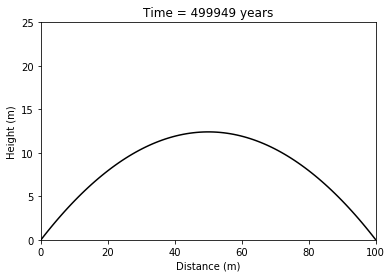

In [4]:
my_movie = run_model()
my_movie

## An example model run with declining relief

Reached maximum height of 0.999931274257494 at t = 327986.9401081476 years.


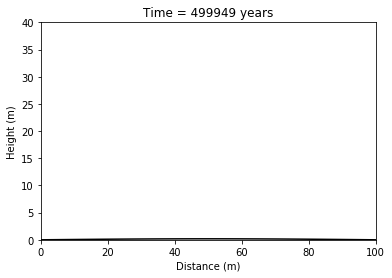

In [5]:
my_movie = run_model(initial_height=20.0, relative_uplift_rate=0.0, relief_cutoff=1.0)
my_movie

## Your turn

Use the cells below to experiment with running the model with different parameters and/or boundary conditions, as indicated in the lab exercise. To run the model and produce a movie, use `my_movie = run_model(`*keyword parameters*`)`. The main parameters that you might want to explore include:

   - run_duration: Number of years to run (default 500,000)
   - creep_coefficient: Creep coefficient, in m$^2$/y (default 0.01)
   - hillslope_length: Length of profile, m (default 100 m)
   - relative_uplift_rate: Rate of 'uplift' relative to baselevel (default 0.1 mm/y)
   - initial_height: Height of initial topography, m (default 0)
   - relief_cutoff: Report when maximum height drops below this value (in m) (default 0)

For example, to run a model with a creep coefficient of 0.001 m$^2$/y and a relative uplift rate of 0.0005, you would create and run a new cell with the code:

`my_movie = run_model(creep_coefficient=0.001, relative_uplift_rate=0.0005)`

`my_movie`